In [2]:
import numpy as np
import pandas as pd
import cv2
import torch
import shutil
import blobfile as bf
from matplotlib import pyplot as plt
# from torch.utils.data import DataLoader, Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torchmetrics import JaccardIndex

In [3]:
target = torch.randint(0, 2, (10, 25, 25))
target

tensor([[[0, 0, 1,  ..., 0, 0, 1],
         [1, 1, 1,  ..., 0, 1, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 1, 1, 0],
         [0, 1, 1,  ..., 0, 1, 1],
         [0, 1, 1,  ..., 1, 0, 1]],

        [[1, 1, 0,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 1, 0, 1],
         ...,
         [1, 0, 1,  ..., 1, 0, 1],
         [0, 1, 1,  ..., 0, 0, 1],
         [1, 0, 1,  ..., 0, 1, 1]],

        [[1, 0, 0,  ..., 1, 1, 1],
         [0, 0, 1,  ..., 1, 1, 0],
         [0, 0, 0,  ..., 0, 1, 1],
         ...,
         [1, 1, 0,  ..., 1, 0, 1],
         [1, 0, 1,  ..., 0, 1, 1],
         [1, 1, 0,  ..., 1, 0, 0]],

        ...,

        [[0, 0, 1,  ..., 0, 0, 1],
         [0, 1, 0,  ..., 0, 1, 0],
         [0, 1, 1,  ..., 0, 0, 1],
         ...,
         [0, 1, 0,  ..., 0, 1, 1],
         [0, 0, 1,  ..., 0, 1, 1],
         [0, 1, 1,  ..., 1, 0, 1]],

        [[0, 0, 1,  ..., 0, 0, 1],
         [1, 0, 1,  ..., 1, 1, 0],
         [0,

In [4]:
pred = torch.tensor(target)
pred.shape

/tmp/ipykernel_435894/3049702626.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(target)


torch.Size([10, 25, 25])

In [5]:
pred[2:5, 7:13, 9:15] = 1 - pred[2:5, 7:13, 9:15]
jaccard = JaccardIndex(task="multiclass", num_classes=2)
jaccard(pred, target)

tensor(0.9660)

In [6]:
def visualize(img):
    '''
    Normalize for visualization.
    '''
    _min = img.min()
    _max = img.max()
    normalized_img = (img - _min) / (_max - _min)
    return normalized_img

In [7]:
def diff(org, sample):
    return abs(visualize(org) - visualize(sample))
    # return abs(visualize(org) - sample)
    # return abs(org - sample)

In [8]:
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()

In [9]:
def visualize(img):
    '''
    Normalize for visualization.
    '''
    _min = img.min()
    _max = img.max()
    normalized_img = (img - _min) / (_max - _min)
    return normalized_img

In [10]:
def heatmap2segmentationmap(difference, threshold=0.2):
    output = []
    for row in difference:
        tmp = []
        for col in row: 
            if col < threshold:
                tmp.append(0)
            else:
                tmp.append(1)
        output.append(tmp)
    return output


In [11]:
def boolean2int_mask(mask):
    output = []
    for row in mask:
        tmp = []
        for col in row: 
            if col:
                tmp.append(1)
            else:
                tmp.append(0)
        output.append(tmp)
    return np.array(output)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


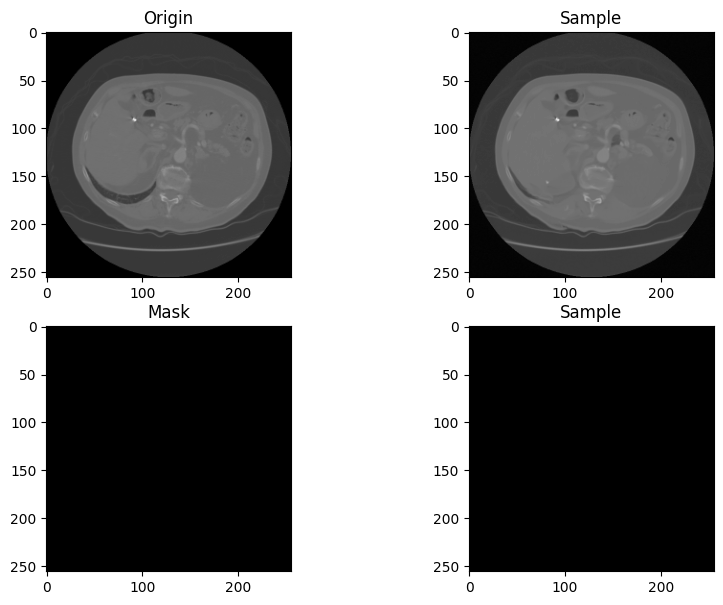

tensor(nan)
tensor(0.2500)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int8)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int8)


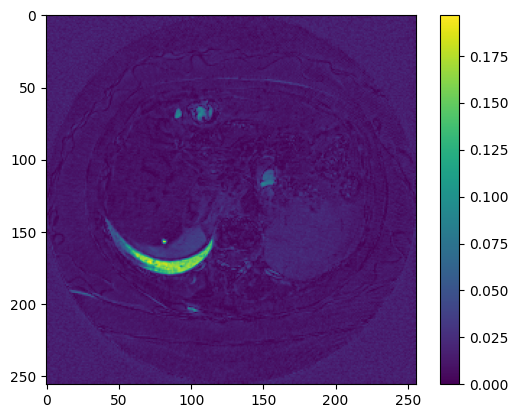

In [18]:
def a(path):
    gt_path = "/home/pill/lung/Pytorch-UNet/test_data/imgs/" + path
    mask_path = "/home/pill/lung/Pytorch-UNet/test_data/masks/" + path
    gt = np.load(gt_path)
    gt = cv2.resize(gt, (256, 256))
    mask = np.load(mask_path).astype('int16')
    mask = cv2.resize(mask, (256, 256))
    # mask = boolean2int_mask(mask)
    print(mask)

    sample_path = "/home/pill/lung/diffusion-anomaly-detection/sample_results/" + path
    sample = np.load(sample_path)
    difference = diff(gt, sample)

    fig = plt.figure(figsize=(10, 7))
    rows = 2
    columns = 2

    fig.add_subplot(rows, columns, 1)
    plt.imshow(gt, cmap='gray')
    plt.title("Origin")

    fig.add_subplot(rows, columns, 2)
    plt.imshow(sample, cmap='gray')
    plt.title("Sample")

    fig.add_subplot(rows, columns, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")

    fig.add_subplot(rows, columns, 4)
    plt.imshow(heatmap2segmentationmap(difference), cmap='gray')
    plt.title("Sample")


    plt.show()

    jaccard = JaccardIndex(task="binary")
    print(jaccard(torch.tensor(mask, dtype=torch.int8), torch.tensor(difference, dtype=torch.int8)))
    print(jaccard(torch.tensor([[1, 0], [0, 1]], dtype=torch.int8), torch.tensor([[1, 1], [1, 0]], dtype=torch.int8)))
    print(torch.tensor(mask, dtype=torch.int8))
    print(torch.tensor(difference, dtype=torch.int8))


    heatmap2d(difference)

a('0001_slice028_0.npy')

In [27]:
files = pd.read_csv("/home/pill/lung/diffusion-anomaly-detection/results/test.csv", header=None)
for i in range(files.__len__()):
    print(files.loc[i][0].split('/')[-1])
    # print(i)
# files

0001_slice097_0.npy
0002_slice074_0.npy
0002_slice152_0.npy
0002_slice174_1.npy
0002_slice177_1.npy
0002_slice180_1.npy
0002_slice214_0.npy
0002_slice220_0.npy
0003_slice043_0.npy
0003_slice067_1.npy
0003_slice068_1.npy
0003_slice075_1.npy
0003_slice126_0.npy
0004_slice053_0.npy
0004_slice116_0.npy
0004_slice190_0.npy
0004_slice219_0.npy
0005_slice001_0.npy
0005_slice018_0.npy
0005_slice059_0.npy
0007_slice042_0.npy
0007_slice107_1.npy
0007_slice109_1.npy
0007_slice111_1.npy
0007_slice134_0.npy
0007_slice144_0.npy
0008_slice000_0.npy
0009_slice022_0.npy
0009_slice055_0.npy
0009_slice115_0.npy
0009_slice159_0.npy
0010_slice024_0.npy
0010_slice071_0.npy
0010_slice141_0.npy
0010_slice144_0.npy
0010_slice179_0.npy
0010_slice207_0.npy
0010_slice209_1.npy
0010_slice210_1.npy
0010_slice216_0.npy
0010_slice265_0.npy
0010_slice272_0.npy
0011_slice038_0.npy
0011_slice058_1.npy
0013_slice045_0.npy
0013_slice105_0.npy
0014_slice001_0.npy
0014_slice023_0.npy
0014_slice030_0.npy
0014_slice065_0.npy


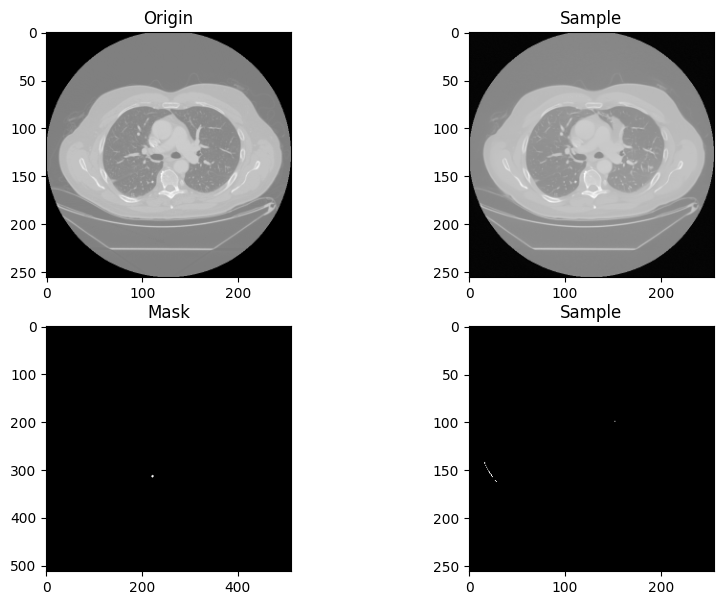

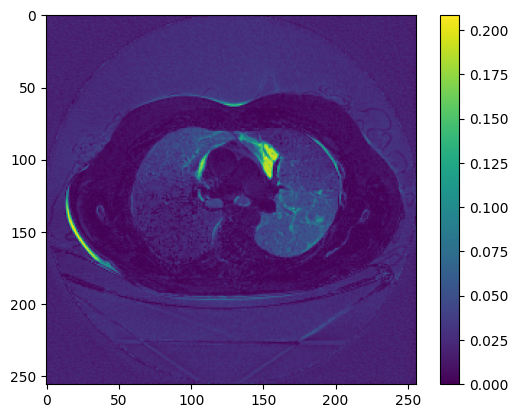

In [ ]:
a("0118_slice160_1.npy")

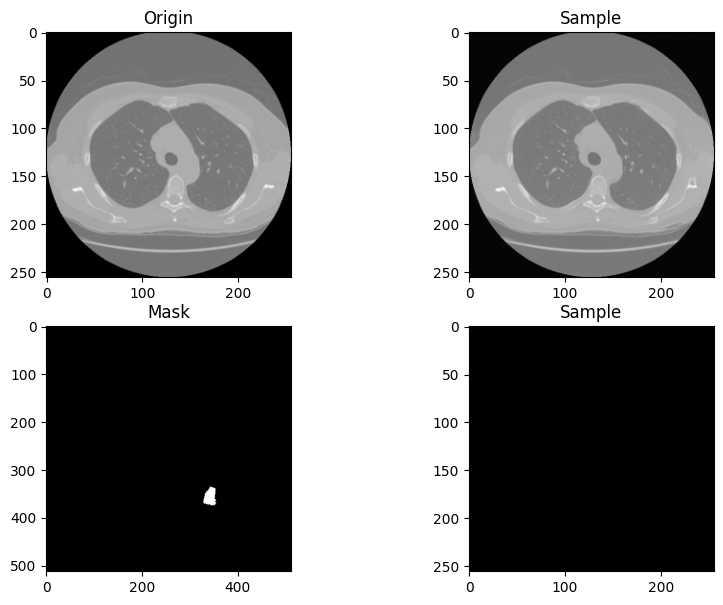

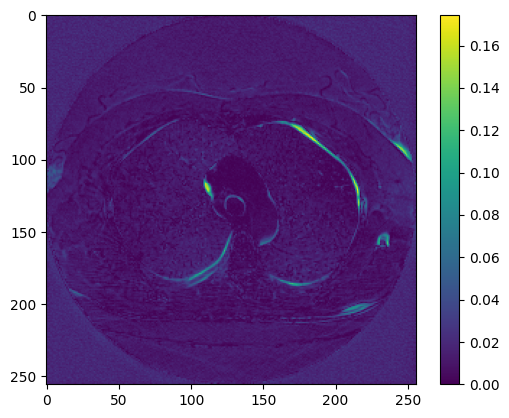

In [ ]:
a("0002_slice177_1.npy")